# 矢量计算
在模型训练或预测时，我们常常会同时处理多个数据样本并用到矢量计算。在介绍线性回归的矢量计算表达式之前，让我们先考虑对两个向量相加的两种方法。
#### 1.向量相加的一种方法是，将这两个向量按元素逐一做标量加法。
#### 2.向量相加的另一种方法是，将这两个向量直接做矢量加法。

In [3]:
import torch
import time
# init variable a, b as 1000 dimension vector

n = 1000
a = torch.ones(n)
b = torch.ones(n)

In [2]:
# 创建一个时间类记录运行时间
class Timer(object):
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        self.start_time = time.time()
    
    def stop(self):
        #计算停止的时间
        self.times.append(time.time() - self.start_time)
        return self.times[-1]
    
    def avg(self):
        return sum(self.times) / len(self.times)
    
    def sum(self):
        return sum(self.times)

In [9]:
timer = Timer()
c = torch.zeros(n)
for i in range(n):
    c[i] = a[i] + b[i]
'%.5f sec' %timer.stop()

'0.05086 sec'

In [10]:
timer = Timer()
d = a + b
'%.5f sec' %timer.stop()

'0.00100 sec'

运行时间上相差500倍，矢量计算更快

## 线性回归从零开始实现 

In [5]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import random
torch.__version__

'1.1.0'

### 生成数据集

In [11]:
num_features = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, num_features, dtype=torch.float32)
print(features)
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()), dtype=torch.float32)

tensor([[ 1.2791,  0.9658],
        [-0.1533, -0.8485],
        [-0.2811,  0.2628],
        ...,
        [ 0.6814,  0.4226],
        [ 0.7554,  0.8171],
        [ 0.2005,  0.3618]])


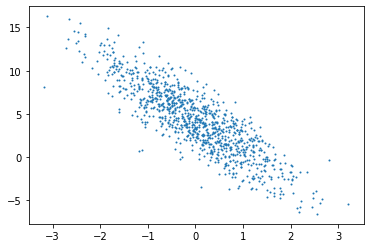

In [12]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

### 读取数据集 

In [24]:
def data_iter(batch_size, features, labels):
    num_examples = len(features) #样本数量
    indices = list(range(num_examples)) # 样本下标
    random.shuffle(indices) #随机打散
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i:min(i+batch_size, num_examples)]) #每次去batch_size个不重样的样本
        yield features.index_select(0,j), labels.index_select(0, j) # 0表示按行取样

### 初始化模型参数

In [16]:
w = torch.tensor(np.random.normal(0, 0.01, (num_features, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
w.requires_grad_(requires_grad=True) #添加梯度法则，利用链式法则
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

### 定义模型

In [15]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

### 定义损失函数

In [17]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

### 定义优化函数

In [20]:
#小批量随机梯度下降
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

### 训练

In [27]:
lr = 0.03
num_epochs = 5
batch_size = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, labels):
        l = loss(net(X,w,b), y).sum()
        l.backward()
        sgd([w,b], lr, batch_size)
        w.grad.data.zero_() #梯度清零
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels) #最终损失
    print(f'epoch {epoch+1}, loss {train_l.mean().item()}')
        

epoch 1, loss 0.00010870503319893032
epoch 2, loss 4.82178402307909e-05
epoch 3, loss 4.819685636903159e-05
epoch 4, loss 4.8189387598540634e-05
epoch 5, loss 4.817238368559629e-05


In [28]:
w, true_w, b, true_b

(tensor([[ 1.9997],
         [-3.4001]], requires_grad=True),
 [2, -3.4],
 tensor([4.1998], requires_grad=True),
 4.2)

## 线性回归使用pytorch的简洁实现

In [33]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(1) #设置随机初始化参数时的随机种子是一致的，保证可以复现
print(torch.__version__)
torch.set_default_tensor_type('torch.FloatTensor') #修改默认tensor类型

1.1.0


### 生成数据集

In [34]:
num_features = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.randn(num_examples, num_features, dtype=torch.float32)
print(features)
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()), dtype=torch.float32)

tensor([[-1.5256, -0.7502],
        [-0.6540, -1.6095],
        [-0.1002, -0.6092],
        ...,
        [ 2.0441, -1.3229],
        [ 1.0491, -2.2162],
        [ 1.0833,  1.5990]])


### 读取数据集

In [37]:
import torch.utils.data as Data
batch_size = 10
dataset = Data.TensorDataset(features, labels)
data_iter = Data.DataLoader(
    dataset=dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

In [38]:
for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[ 0.0191,  1.6940],
        [ 1.1017, -0.1759],
        [-0.3420, -0.6605],
        [-0.5564,  0.4420],
        [-0.8513, -0.8662],
        [ 0.1633,  1.1105],
        [ 0.4543, -1.0420],
        [-1.4244, -1.3247],
        [-0.8824, -0.4934],
        [-1.5032,  1.2445]]) 
 tensor([-1.5056,  6.9920,  5.7658,  1.5877,  5.4429,  0.7612,  8.6737,  5.8647,
         4.1074, -3.0215])


### 定义模型

In [42]:
# ways to init a multilayer network
# method one
net = nn.Sequential(
    nn.Linear(num_features, 1)
    # other layers can be added here
    )

# method two
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_features, 1))
# net.add_module ......

# method three
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
          ('linear', nn.Linear(num_features, 1))
          # ......
        ]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


### 初始化模型参数

In [45]:
from torch.nn import init

init.normal_(net[0].weight, mean=0.0, std=0.01)
init.constant_(net[0].bias, val=0.0)

Parameter containing:
tensor([0.], requires_grad=True)

In [46]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0019,  0.0095]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


### 定义损失函数

In [47]:
loss = nn.MSELoss()

### 定义优化函数

In [48]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### 训练

In [49]:
num_epochs = 3
for epoch in range(1, num_epochs+1):
    for X,y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1,1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print(f'epoch {epoch}, loss:{l.item()}')

epoch 1, loss:0.0003279556112829596
epoch 2, loss:5.6046883400995284e-05
epoch 3, loss:0.00021316026686690748


In [50]:
# result comparision
dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 1.9994, -3.4015]])
4.2 tensor([4.2006])
